In [ ]:
# https://www.youtube.com/watch?v=aySurynUNAw&ab_channel=BleedAIAcademy

# **<center><font style="color:rgb(100,109,254)">Real-Time 3D Pose Detection & Pose Classification with Mediapipe and Python</font> </center>**

Pose Detection (also known as Pose Estimation) is a widely used computer vision task that enables you to predict humans poses in images or videos by localizing the key body joints (also reffered  as landmarks), these are elbows, shoulders, and knees, etc. 

<img src='https://drive.google.com/uc?export=download&id=1hT-lhDvzft8vVQv6ObSok73h7A4l5CXf'>


[MediaPipe](https://google.github.io/mediapipe/solutions/pose.html) provides a robust solution capable of predicting **thirty-three 3D landmarks** on a human body in real-time with high accuracy even on CPU. It utilizes a two-step machine learning pipeline, by using a detector it first localizes the person within the frame and then uses the pose landmarks detector to predict the  landmarks within the region of interest.


<img src='https://drive.google.com/uc?export=download&id=1c1vFXlRbN9r4ONKIE3sEmaLsWEfm2vpF'>


For the videos, the detector is used only for the very first frame and then the ROI is derived from the previous frame’s pose landmarks using a tracking method. Also when the tracker loses track of the identify body pose presence in a frame, the detector is invoked again for the next frame which reduces the computation and latency. The image below shows the thirty-three pose landmarks along with their indexes.

<img src="https://drive.google.com/uc?export=download&id=1CDO0KiXZEOuWc7xLEm7EFLLQf2hydCoI">

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

Let's start by importing the required libraries.

In [1]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

## **<font style="color:rgb(134,19,348)">Initialize the Pose Detection Model</font>**

The first thing that we need to do is initialize the pose class using the **`mp.solutions.pose`** syntax and then we will call the setup function **`mp.solutions.pose.Pose()`** with the arguments:

* **`static_image_mode`** - It is a boolean value that is if set to `False`, the detector is only invoked as needed, that is in the very first frame or when the tracker loses track. If set to `True`, the person detector is invoked on every input image. So you should probably set this value to True when working with a bunch of unrelated images not videos. Its default value is `False`.

* **`min_detection_confidence`** - It is the minimum detection confidence with range `(0.0 , 1.0)` required to consider the person-detection model's prediction correct. Its default value is `0.5`. This means if the detector has a prediction confidence of greater or equal to 50% then it will be considered as a positive detection.


* **`min_tracking_confidence`** - It is the minimum tracking confidence `([0.0, 1.0])` required to consider the landmark-tracking model's tracked pose landmarks valid. If the confidence is less than the set value then the detector is invoked again in the next frame/image, so increasing its value increases the robustness, but also increases the latency. Its default value is `0.5`.


* **`model_complexity`** - It is the complexity of the pose landmark model. As there are three different models to choose from so the possible values are `0`, `1`, or `2`. The higher the value, the more accurate the results are, but at the expense of higher latency. Its default value is `1`.


* **`smooth_landmarks`** - It is a boolean value that is if set to `True`, pose landmarks across different frames are filtered to reduce noise. But only works when **`static_image_mode`** is also set to `False`. Its default value is `True`.

Then we will also initialize **`mp.solutions.drawing_utils`** class that will allow us to visualize the landmarks after detection, instead of using this, you can also use OpenCV to visualize the landmarks.

In [2]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

### **<font style="color:rgb(134,19,348)">Read an Image</font>**

Now we will read a sample image using the function [**`cv2.imread()`**](https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56) and then display that image using the [**`matplotlib`**](https://matplotlib.org/stable/index.html) library. 

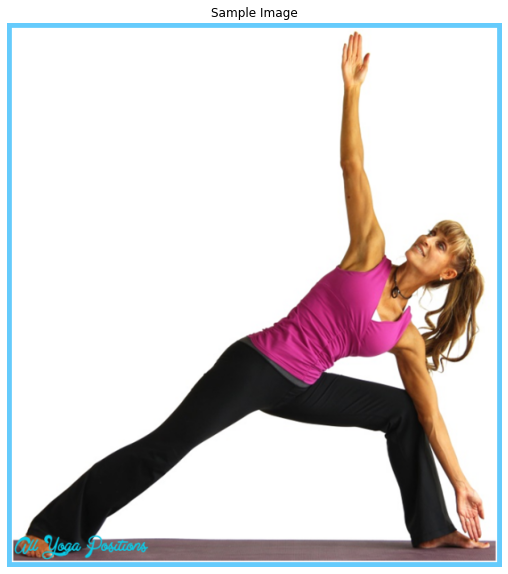

In [6]:
tempName = r"C:\Users\mckay\Desktop\School\winter 2023\EECS 448\DG_Capstone\yoga\Extended_Revolved_Side_Angle_Pose_or_Utthita_Parsvakonasana_\Extended_Revolved_Side_Angle_Pose_or_Utthita_Parsvakonasana__45.jpg"

# Read an image from the specified path.
sample_img = cv2.imread(tempName)

# Specify a size of the figure.
plt.figure(figsize = [10, 10])

# Display the sample image, also convert BGR to RGB for display. 
plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

## **<font style="color:rgb(134,19,348)">Perform Pose Detection</font>**

Now we will pass the image to the pose detection machine learning pipeline by using the function **`mp.solutions.pose.Pose().process()`**. But the pipeline expects the input images in **`RGB`** color format so first we will have to convert the sample image from **`BGR`** to **`RGB`** format using the function [**`cv2.cvtColor()`**](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab) as OpenCV reads images in **`BGR`** format (instead of **`RGB`**).

After performing the pose detection, we will get a list of thirty-three landmarks representing the body joint locations of the prominent person in the image. Each landmark has:

* **`x`** - It is the landmark x-coordinate normalized to [0.0, 1.0] by the image width.


* **`y`**: It is the landmark y-coordinate normalized to [0.0, 1.0] by the image height.


* **`z`**: It is the landmark z-coordinate normalized to roughly the same scale as **`x`**. It represents the landmark depth with midpoint of hips being the origin, so the smaller the value of z, the closer the landmark is to the camera. 

* **`visibility`**: It is a value with range [0.0, 1.0] representing the possibility of the landmark being visible (not occluded) in the image. This is a useful variable when deciding if you want to show a particular joint because it might be occluded or partially visible in the image.

After performing the pose detection on the sample image above, we will display the first two landmarks from the list, so that you get a better idea of the output of the model.

In [7]:
# Perform pose detection after converting the image into RGB format.
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

# Check if any landmarks are found.
if results.pose_landmarks:
    
    # Iterate two times as we only want to display first two landmarks.
    for i in range(32):
        
        # Display the found normalized landmarks.
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}') 

NOSE:
x: 0.8508473038673401
y: 0.40726029872894287
z: -0.44240641593933105
visibility: 0.9999974966049194

LEFT_EYE_INNER:
x: 0.8750582337379456
y: 0.41117724776268005
z: -0.4148544669151306
visibility: 0.999988317489624

LEFT_EYE:
x: 0.8805875182151794
y: 0.41751325130462646
z: -0.41528549790382385
visibility: 0.9999890327453613

LEFT_EYE_OUTER:
x: 0.8856573104858398
y: 0.424356609582901
z: -0.41509804129600525
visibility: 0.9999866485595703

RIGHT_EYE_INNER:
x: 0.8622192740440369
y: 0.3973458409309387
z: -0.4053434729576111
visibility: 0.9999923706054688

RIGHT_EYE:
x: 0.8591501712799072
y: 0.39473453164100647
z: -0.40599021315574646
visibility: 0.9999946355819702

RIGHT_EYE_OUTER:
x: 0.8567506074905396
y: 0.39249590039253235
z: -0.40636059641838074
visibility: 0.9999949932098389

LEFT_EAR:
x: 0.8880862593650818
y: 0.4519686698913574
z: -0.25935521721839905
visibility: 0.9999866485595703

RIGHT_EAR:
x: 0.8556579351425171
y: 0.4070643484592438
z: -0.22030867636203766
visibility: 0.999

Now we will convert the two normalized landmarks displayed above into their original scale by using the width and height of the  image.

In [5]:
# Retrieve the height and width of the sample image.
image_height, image_width, _ = sample_img.shape

# Check if any landmarks are found.
if results.pose_landmarks:
    
    # Iterate two times as we only want to display first two landmark.
    for i in range(2):
        
        # Display the found landmarks after converting them into their original scale.
        print(f'{mp_pose.PoseLandmark(i).name}:') 
        print(f'x: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x * image_width}')
        print(f'y: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y * image_height}')
        print(f'z: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z * image_width}')
        print(f'visibility: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].visibility}\n')

NOSE:
x: 522.4202445745468
y: 274.90070164203644
z: -271.63753938674927
visibility: 0.9999974966049194

LEFT_EYE_INNER:
x: 537.2857555150986
y: 277.54464223980904
z: -254.7206426858902
visibility: 0.999988317489624



Now we will draw the detected landmarks on the sample image using the function **`mp.solutions.drawing_utils.draw_landmarks()`** and display the resultant image using the [**`matplotlib`**](https://matplotlib.org/stable/index.html) library. 

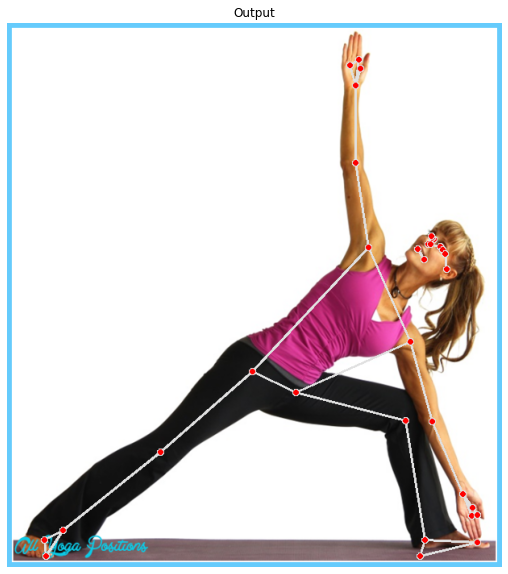

In [6]:
# Create a copy of the sample image to draw landmarks on.
img_copy = sample_img.copy()

# Check if any landmarks are found.
if results.pose_landmarks:
    
    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
       
    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])

    # Display the output image with the landmarks drawn, also convert BGR to RGB for display. 
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

Now we will go a step further and visualize the landmarks in three-dimensions (3D) using the function **`mp.solutions.drawing_utils.plot_landmarks()`**. We will need the POSE_WORLD_LANDMARKS that is another list of pose landmarks in world coordinates that has the 3D coordinates in meters with the origin at the center between the hips of the person. 

<img src='https://drive.google.com/uc?export=download&id=1JPQCLOPZkS8b3VBNtmc2aOfuAjhddSMZ' width=400>

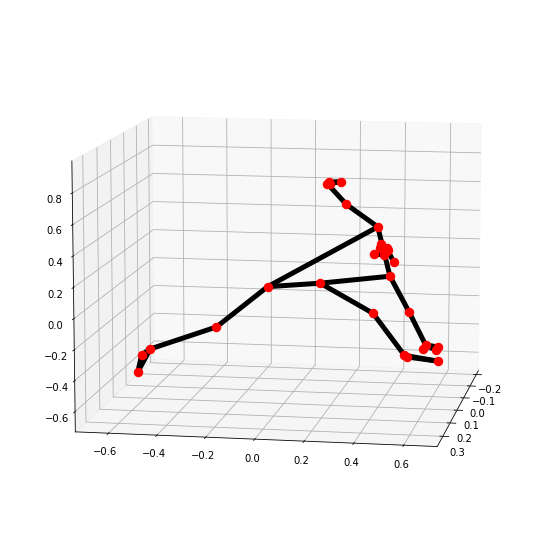

In [7]:
# Plot Pose landmarks in 3D.
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

**Note:** This is actually a neat hack by mediapipe, the coordinates returned are not actually in **3D** but by setting hip landmark as the origin allows us to measure relative distance of the other points from the hip, and since this distance increases or decreases depending upon if you're close or further from the camera it gives us a sense of depth of each landmark point. 

### **<font style="color:rgb(134,19,348)">Create a Pose Detection Function</font>**

Now we will put all this together to create a function that will perform pose detection on an image and will visualize the results or return the results depending upon the passed arguments.

In [3]:
def detectPose(image, pose, display=True):
    '''
    This function performs pose detection on an image.
    Args:
        image: The input image with a prominent person whose pose landmarks needs to be detected.
        pose: The pose setup function required to perform the pose detection.
        display: A boolean value that is if set to true the function displays the original input image, the resultant image, 
                 and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn.
        landmarks: A list of detected landmarks converted into their original scale.
    '''
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(imageRGB)
    
    # Retrieve the height and width of the input image.
    height, width, _ = image.shape
    
    # Initialize a list to store the detected landmarks.
    landmarks = []
    
    # Check if any landmarks are detected.
    if results.pose_landmarks:
    
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:
            
            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
    
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        # Also Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        
    # Otherwise
    else:
        
        # Return the output image and the found landmarks.
        return output_image, landmarks

Now we will utilize the function created above to perform pose detection on a few sample images and display the results.

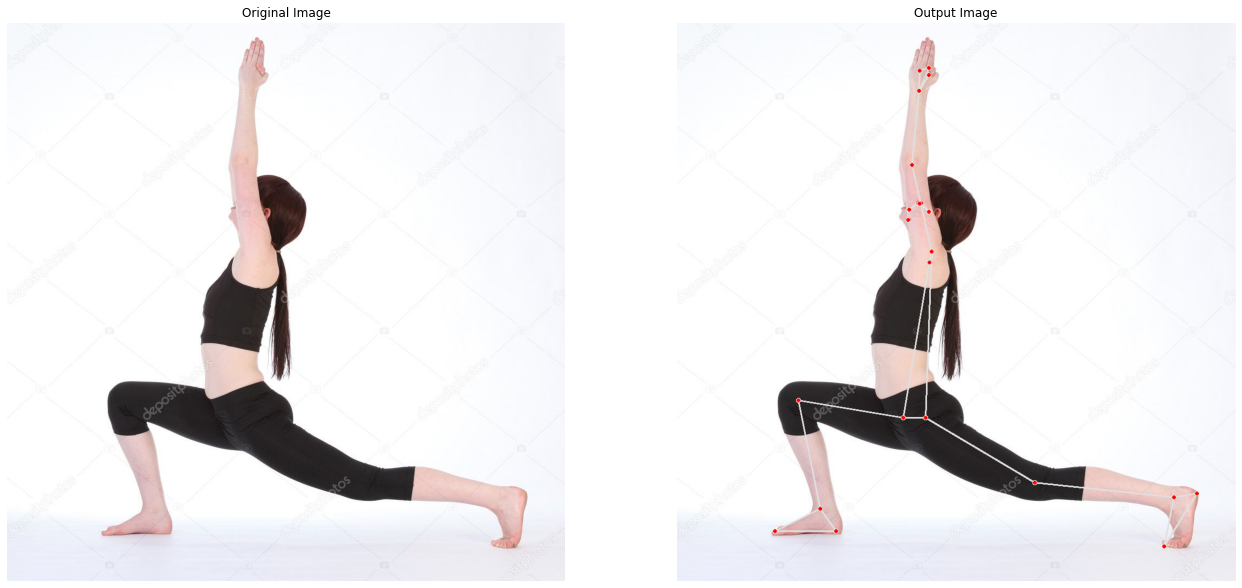

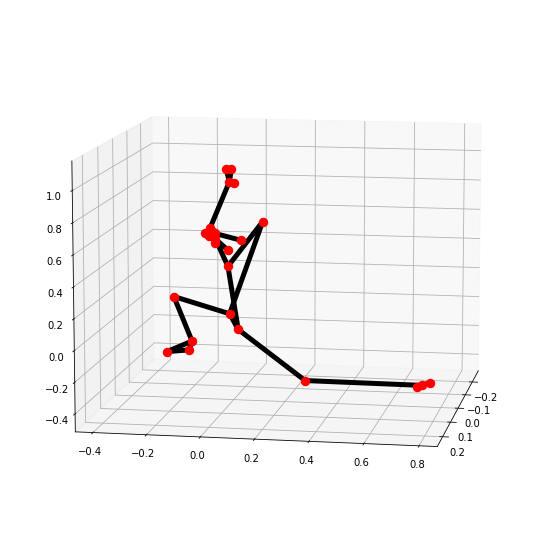

In [16]:
# Read another sample image and perform pose detection on it.
image = cv2.imread(r"C:\Users\mckay\Desktop\School\winter 2023\EECS 448\DG_Capstone\yoga\Warrior_I_Pose_or_Virabhadrasana_I_\Warrior_I_Pose_or_Virabhadrasana_I__135.jpg")
detectPose(image, pose, display=True)

### **<font style="color:rgb(134,19,348)">Pose Detection On Real-Time Webcam Feed/Video</font>**

The results on the images were pretty good, now we will try the function on a real-time webcam feed and a video. Depending upon whether you want to run pose detection on a video stored in the disk or on the webcam feed, you can comment and uncomment the initialization code of the VideoCapture object accordingly.

In [5]:
# Setup Pose function for video.
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# Initialize the VideoCapture object to read from the webcam.
video = cv2.VideoCapture(0)

# Create named window for resizing purposes
cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)


# Initialize the VideoCapture object to read from a video stored in the disk.
#video = cv2.VideoCapture('media/running.mp4')

# Set video camera size
video.set(3,1280)
video.set(4,960)

# Initialize a variable to store the time of the previous frame.
time1 = 0

# Iterate until the video is accessed successfully.
while video.isOpened():
    
    # Read a frame.
    ok, frame = video.read()
    
    # Check if frame is not read properly.
    if not ok:
        
        # Break the loop.
        break
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the width and height of the frame
    frame_height, frame_width, _ =  frame.shape
    
    # Resize the frame while keeping the aspect ratio.
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
    
    # Perform Pose landmark detection.
    frame, _ = detectPose(frame, pose_video, display=False)
    
    # Set the time for this frame to the current time.
    time2 = time()
    
    # Check if the difference between the previous and this frame time > 0 to avoid division by zero.
    if (time2 - time1) > 0:
    
        # Calculate the number of frames per second.
        frames_per_second = 1.0 / (time2 - time1)
        
        # Write the calculated number of frames per second on the frame. 
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    
    # Update the previous frame time to this frame time.
    # As this frame will become previous frame in next iteration.
    time1 = time2
    
    # Display the frame.
    cv2.imshow('Pose Detection', frame)
    
    # Wait until a key is pressed.
    # Retreive the ASCII code of the key pressed
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed.
    if(k == 27):
        
        # Break the loop.
        break

# Release the VideoCapture object.
video.release()

# Close the windows.
cv2.destroyAllWindows()

KeyboardInterrupt: 

Cool! so it works great on the videos too. The model is pretty fast and accurate.

## **<font style="color:rgb(134,19,348)">Pose Classification with Angle Heuristics</font>**

We have learned to perform pose detection, now we will level up our game by also classifying different yoga poses using the calculated angles of various joints. We will first detect the pose landmarks and then use them to compute angles between joints and depending upon those angles we will recognize the yoga pose of the prominent person in an image.

<img src='https://drive.google.com/uc?export=download&id=1lhAcgq2jy5NavGQeYjTwwEAZIu6Aeypg' width=500>

But this approach does have a drawback that limits its use to a controlled environment, the calculated angles vary with the angle between the person and the camera. So the person needs to be facing the camera straight to get the best results.

### **<font style="color:rgb(134,19,348)">Create a Function to Calculate Angle between Landmarks</font>**

Now we will create a function that will be capable of calculating angles between three landmarks. The angle between landmarks? Do not get confused, as this is the same as calculating the angle between two lines. 

The first point (landmark) is considered as the starting point of the first line, the second point (landmark) is considered as the ending point of the first line and the starting point of the second line as well, and the third point (landmark) is considered as the ending point of the second line.

<img src='https://drive.google.com/uc?export=download&id=1KSN2OnenNMZ7Jwai_E1jeWdP5Mzay3Ad' width=400>

In [ ]:
def calculateAngle(landmark1, landmark2, landmark3):
    '''
    This function calculates angle between three different landmarks.
    Args:
        landmark1: The first landmark containing the x,y and z coordinates.
        landmark2: The second landmark containing the x,y and z coordinates.
        landmark3: The third landmark containing the x,y and z coordinates.
    Returns:
        angle: The calculated angle between the three landmarks.

    '''

    # Get the required landmarks coordinates.
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3

    # Calculate the angle between the three points
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    
    # Check if the angle is less than zero.
    if angle < 0:

        # Add 360 to the found angle.
        angle += 360
    
    # Return the calculated angle.
    return angle

Now we will test the function created above to calculate angle three landmarks with dummy values.

In [ ]:
# Calculate the angle between the three landmarks.
angle = calculateAngle((558, 326, 0), (642, 333, 0), (718, 321, 0))

# Display the calculated angle.
print(f'The calculated angle is {angle}')

### **<font style="color:rgb(134,19,348)">Create a Function to Perform Pose Classification</font>**

Now we will create a function that will be capable of classifying different yoga poses using the calculated angles of various joints. The function will be capable of identifying the following yoga poses:

* **Warrior II Pose**
* **T Pose**
* **Tree Pose**

In [ ]:
def classifyPose(landmarks, output_image, display=False):
    '''
    This function classifies yoga poses depending upon the angles of various body joints.
    Args:
        landmarks: A list of detected landmarks of the person whose pose needs to be classified.
        output_image: A image of the person with the detected pose landmarks drawn.
        display: A boolean value that is if set to true the function displays the resultant image with the pose label 
        written on it and returns nothing.
    Returns:
        output_image: The image with the detected pose landmarks drawn and pose label written.
        label: The classified pose label of the person in the output_image.

    '''
    
    # Initialize the label of the pose. It is not known at this stage.
    label = 'Unknown Pose'

    # Specify the color (Red) with which the label will be written on the image.
    color = (0, 0, 255)
    
    # Calculate the required angles.
    #----------------------------------------------------------------------------------------------------------------
    
    # Get the angle between the left shoulder, elbow and wrist points. 
    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    
    # Get the angle between the right shoulder, elbow and wrist points. 
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])   
    
    # Get the angle between the left elbow, shoulder and hip points. 
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])

    # Get the angle between the right hip, shoulder and elbow points. 
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])

    # Get the angle between the left hip, knee and ankle points. 
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])

    # Get the angle between the right hip, knee and ankle points 
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if it is the warrior II pose or the T pose.
    # As for both of them, both arms should be straight and shoulders should be at the specific angle.
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if the both arms are straight.
    if left_elbow_angle > 165 and left_elbow_angle < 195 and right_elbow_angle > 165 and right_elbow_angle < 195:

        # Check if shoulders are at the required angle.
        if left_shoulder_angle > 80 and left_shoulder_angle < 110 and right_shoulder_angle > 80 and right_shoulder_angle < 110:

    # Check if it is the warrior II pose.
    #----------------------------------------------------------------------------------------------------------------

            # Check if one leg is straight.
            if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:

                # Check if the other leg is bended at the required angle.
                if left_knee_angle > 90 and left_knee_angle < 120 or right_knee_angle > 90 and right_knee_angle < 120:

                    # Specify the label of the pose that is Warrior II pose.
                    label = 'Warrior II Pose' 
                        
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if it is the T pose.
    #----------------------------------------------------------------------------------------------------------------
    
            # Check if both legs are straight
            if left_knee_angle > 160 and left_knee_angle < 195 and right_knee_angle > 160 and right_knee_angle < 195:

                # Specify the label of the pose that is tree pose.
                label = 'T Pose'

    #----------------------------------------------------------------------------------------------------------------
    
    # Check if it is the tree pose.
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if one leg is straight
    if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:

        # Check if the other leg is bended at the required angle.
        if left_knee_angle > 315 and left_knee_angle < 335 or right_knee_angle > 25 and right_knee_angle < 45:

            # Specify the label of the pose that is tree pose.
            label = 'Tree Pose'
                
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if the pose is classified successfully
    if label != 'Unknown Pose':
        
        # Update the color (to green) with which the label will be written on the image.
        color = (0, 255, 0)  
    
    # Write the label on the output image. 
    cv2.putText(output_image, label, (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, color, 2)
    
    # Check if the resultant image is specified to be displayed.
    if display:
    
        # Display the resultant image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    else:
        
        # Return the output image and the classified label.
        return output_image, label

Now we will utilize the function created above to perform pose classification on a few images of people and display the results.

## **<font style="color:rgb(134,19,348)">Warrior II Pose</font>**

The Warrior II Pose (also known as Virabhadrasana II) is the same pose that the person is making in the image above. It can be classified using the following combination of body part angles:

* Around 180° at both elbows
* Around 90° angle at both shoulders
* Around 180° angle at one knee
* Around 90° angle at the other knee


In [ ]:
# Read a sample image and perform pose classification on it.
image = cv2.imread(r"C:\Users\mckay\Desktop\School\winter 2023\EECS 448\DG_Capstone\yoga\Warrior_II_Pose_or_Virabhadrasana_II_\Warrior_II_Pose_or_Virabhadrasana_II__22.jpg")
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

## **<font style="color:rgb(134,19,348)">Tree Pose</font>**

Tree Pose (also known as Vrikshasana) is another yoga pose for which the person has to keep one leg straight and bend the other leg at a required angle. The pose can be classified easily using the following combination of body part angles:

* Around 180° angle at one knee
* Around 35° (if right knee) or 335° (if left knee) angle at the other knee

Now to understand it better, you should go back to the pose classification function above to overview the classification code of this yoga pose.

We will perform pose classification on a few images of people in the tree yoga pose and display the results using the same function we had created above.

In [ ]:
# Read a sample image and perform pose classification on it.
image = cv2.imread(r"C:\Users\mckay\Desktop\School\winter 2023\EECS 448\DG_Capstone\yoga\Tree_Pose_or_Vrksasana_\Tree_Pose_or_Vrksasana__58.jpg")
output_image, landmarks = detectPose(image, mp_pose.Pose(static_image_mode=True,
                                         min_detection_confidence=0.5, model_complexity=0), display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

## **<font style="color:rgb(134,19,348)">T Pose</font>**

T Pose (also known as a bind pose or reference pose) is the last pose we are dealing with in this lesson. To make this pose, one has to stand up like a tree with both hands wide open as branches. The following body part angles are required to make this one:

* Around 180° at both elbows
* Around 90° angle at both shoulders
* Around 180° angle at both knees

You can now go back to go through the classification code of this T pose in the pose classification function created above.

Now, let's test the pose classification function on a few images of the T pose.

In [ ]:
# Read another sample image and perform pose classification on it.
image = cv2.imread('media/Tpose1.jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

So the function is working pretty well on all the known poses on images lets try it on an unknown pose called cobra pose (also known as Bhujangasana).

In [ ]:
# Read another sample image and perform pose classification on it.
image = cv2.imread('media/cobrapose1.jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

Now if you want you can extend the pose classification function to make it capable of identifying more yoga poses like the one in the image above. The following combination of body part angles can help classify this one:

* Around 180° angle at both knees
* Around 105° (if the person is facing right side) or 240° (if the person is facing left side) angle at both hips

### **<font style="color:rgb(134,19,348)">Pose Classification On Real-Time Webcam Feed</font>**

Now we will test the function created above to perform the pose classification on a real-time webcam feed. 

In [ ]:
# Setup Pose function for video.
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Initialize a resizable window.
cv2.namedWindow('Pose Classification', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly.
    if not ok:
        
        # Continue to the next iteration to read the next frame and ignore the empty camera frame.
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the width and height of the frame
    frame_height, frame_width, _ =  frame.shape
    
    # Resize the frame while keeping the aspect ratio.
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
    
    # Perform Pose landmark detection.
    frame, landmarks = detectPose(frame, pose_video, display=False)
    
    # Check if the landmarks are detected.
    if landmarks:
        
        # Perform the Pose Classification.
        frame, _ = classifyPose(landmarks, frame, display=False)
    
    # Display the frame.
    cv2.imshow('Pose Classification', frame)
    
    # Wait until a key is pressed.
    # Retreive the ASCII code of the key pressed
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed.
    if(k == 27):
        
        # Break the loop.
        break

# Release the VideoCapture object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

As expected, the results were amazing, if you were having difficulty in making the poses you can expand the range of angles used in the classification function, but that may open up the possibility of false positives.

#  <center> <font style="color:rgb(234,19,148)">Join My Mediapipe Course</font>   </center>

You can now join the waitlist for my brand new upcoming course on Mediapipe, I’m not going to any details now but I’m just going to say this course will be a Blast, to say the least. This will be a completely application-oriented course and it will train you on how to create State of the Art exciting applications.

<img src='https://drive.google.com/uc?export=download&id=1CP0jp5rlTkOuj23PzUeGGi3NknXVI3wi'>

<br>
<br>

<center>  <a href="https://www.getdrip.com/forms/677961673/submissions/new"> <button>Join Now!</button>
</a></center>
    
